# Статистика, DS-поток
## Практическое задание 14


**Правила:**

* Дедлайн **18 декабря 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 &mdash; 8 баллов.

**Важность задач:**

* *средняя:* задача 1.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', font_scale=1.7)

## Задача 1.

При решении задачи классификации, как и обсуждалось на занятии, нам часто требуется помимо метки класса предсказать еще и вероятность принадлежности соответствующему классу. Использование оценок вероятностей дает некоторую гибкость при решении задачи, ведь мы оставляем за собой право на то, как именно интепретировать эти оценки вероятности. Например, мы можем легко поменять порог для бинарной классификации и получить некоторый прирост по целевым метриками. 

При использовании моделей, которые предсказывают вероятности, хотелось, чтобы оценки вероятностей хорошо оценивали сами вероятности. Другими словами, если мы рассмотрим множество объектов, для которых $\sigma(\theta^Tx) \approx 0.8$, то разумно ожидать, что около $80\%$ из этих рассмотренных объектов действительно имеют положительную метку. Существуют некоторые методы для оценки того, насколько хорошо скалибрована модель, а также средства для калибровки оценок вероятностей. 

Как понять, явлется ли модель скалиброванной? Для этого можно посмотреть на:

* Калибровочные кривые.  При построении графика мы сопоставляем истинную частоту положительной метки с ее оценкой вероятностью. 

* Гистограммы для распределения оценок вероятностей.  

Рассмотрим пример из [sklearn](https://scikit-learn.org/stable/modules/calibration.html#calibration).

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_compare_calibration_001.png)

На первом графике изображены калибровочные кривые. По оси Y нанесены истинные частоты положительного класса, а по оси X &mdash; средняя оценка вероятности. На графике также можно заметить линию, которая изображает идеально-скалиброванную модель.

На графиках ниже изображены гистограммы значений предсказанных оценок вероятности для разных моделей.

Не будем говорить о поведении двух моделей (SVC и RandomFores), т.к. их изучением мы займемся весной. Рассмотрим поведение логистической регрессии и Naive Bayes. Можно заметить,что прогнозы для логистической регрессии оказываются достаточно хорошо-скалиброванными, в то время как NaiveBayes иногда имеет слишком завышенный или, наоборот, заниженный прогноз. Подобное поведение может оказаться критичным, например, в задаче кредитного скоринга, где недооценка рисков может привести к потере средств.

Существует некоторое количество методов для калибровки. Наиболее простым методом считается гистограммная
калибровка. Рассмотрим ее чуть подробнее. Разобьем отрезок $[0, 1]$ на бакеты $B_1, \ldots, B_K$ и каждому бакету поставим в соответствие число $\theta_j$.
Тогда, если модель для объекта $x$ оценила вероятность его принадлежности положительному классу как $\widehat{p}(x)$, то в качестве итоговой оценки вероятности возьмем $\theta_j$ для такого $j$, что выполнено $\widehat{p}(x) \in B_j$. Параметры $\theta_j$ оценим по калибровочной выборке как долю объектов положительного класса среди тех, для которых $\widehat{p}(x) \in B_j$.

Про методы калибровки, реализованные в `sklearn` можно прочитать [здесь](https://scikit-learn.org/stable/modules/calibration.html#calibration).

Посмотрим на калибровку на простом примере. Загрузите заранее сгенерированные данные из файла `data.csv`.

In [2]:
data = pd.read_csv('data.csv')
data

,feature_0,feature_1,target
0,-0.507535,0.624721,0
1,1.439515,5.777539,1
2,1.436511,1.885675,1
3,-1.064369,1.463578,0
4,-1.496488,0.770633,0
...,...,...,...
19995,-0.750862,-2.607425,0
19996,0.953353,-1.118619,1
19997,4.101143,4.749728,0
19998,2.175595,3.046624,0


Визуализируйте загруженные данные выборку.

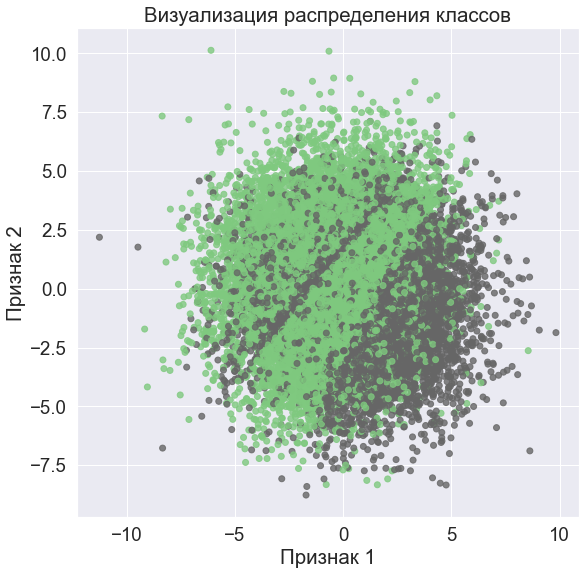

In [10]:
x = np.linspace(np.min(data['feature_0'].to_numpy()) - 1, np.max(data['feature_0'].to_numpy()) + 1, 1000)
y = np.linspace(np.min(data['feature_1'].to_numpy()) - 1, np.max(data['feature_1'].to_numpy()) + 1, 1000)
x, y = np.meshgrid(x, y)

plt.figure(figsize=(9, 9))
plt.scatter(data['feature_0'], data['feature_1'], c=data['target'], alpha=0.8, cmap='Accent')
plt.xlabel(f'Признак 1')
plt.ylabel(f'Признак 2')
plt.title('Визуализация распределения классов')
plt.show()

Видно, что классы сложно назвать линейно разделимыми, хотя заметно, что "зеленый" класс больше располагается вверху-слева, в то время, как "черный" &mdash; внизу-справа.

**1.** Для начала проверим линейность логита. Опишите процедуру проверки линейности логита в логистической регрессии с помощью сглаженных диаграмм рассеяния.

**Ответ:** сначала строим ядерную регрессию &mdash; приближение вероятности класса 1 в зависимости от $x_j$: 

$$\widehat{y}(x_j) = \frac{\sum\limits_{i = 1}^{n} q\left(\frac{x_j - x_{ij}}{h}\right)Y_i}{\sum\limits_{i = 1}^{n} q\left(\frac{x_j - x_{ij}}{h}\right)}.$$

Далее через найденное приближение считаем приближение логита: $logit(x_i) = \log{\frac{\widehat{y}(x_j)}{1 - \widehat{y}(x_j)}}.$
Наконец, строим график и проверяем его на линейность.

Реализуем эту процедуру для сгенерированных данных.

In [17]:
x = np.linspace(0, 1, 1001)
np.repeat(x, 2).reshape((-1, 2)).T

array([[0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ],
       [0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ]])

In [21]:
X = data[['feature_0', 'feature_1']].to_numpy()
Y = data['target'].to_numpy()
X.shape, Y

((20000, 2), array([0, 1, 1, ..., 0, 0, 1], dtype=int64))

In [34]:
X[:, 0].min()

-11.256467201963703

In [62]:
x = X[:, 0]
z = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 10).reshape((1, -1))
z.shape

(1, 10)

In [64]:
x = X[:, 0].reshape((-1, 1))
z - x

array([[-11.74893265,  -9.183841  ,  -6.61874936, ...,   6.20670887,
          8.77180051,  11.33689216],
       [-13.69598186, -11.13089022,  -8.56579857, ...,   4.25965966,
          6.8247513 ,   9.38984295],
       [-13.69297852, -11.12788688,  -8.56279523, ...,   4.262663  ,
          6.82775464,   9.39284629],
       ...,
       [-16.35761052, -13.79251887, -11.22742723, ...,   1.598031  ,
          4.16312264,   6.72821429],
       [-14.43206214, -11.8669705 ,  -9.30187885, ...,   3.52357938,
          6.08867102,   8.65376267],
       [-13.56278384, -10.99769219,  -8.43260055, ...,   4.39285768,
          6.95794932,   9.52304097]])

(20000, 1000)
(1000,)
(20000, 1000)
(1000,)


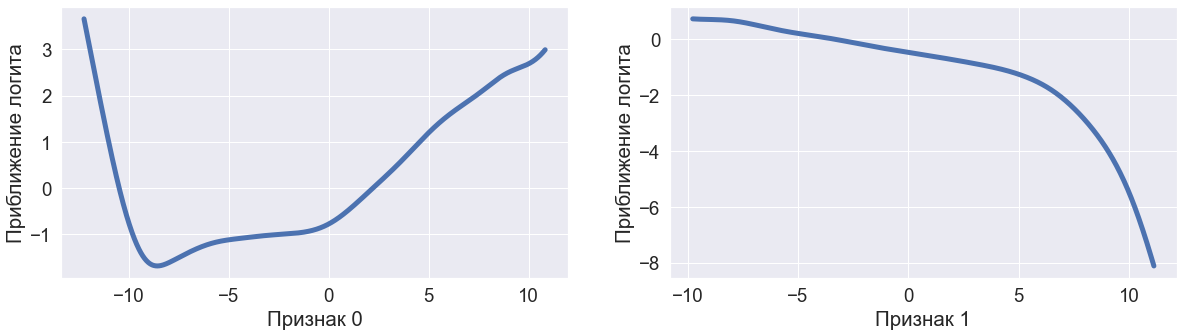

In [70]:
h = 1  # ширина ядра
n = X.shape[0]

plt.figure(figsize=(20, 5))
# цикл по признакам
for feature_idx in range(X.shape[1]):
    # отсортированная сетка по признаку feature_idx
    # для построения ядерной оценки
    x_grid = np.linspace(np.min(X[:, feature_idx]) - 1, np.max(X[:, feature_idx]) + 1, 1000)
    # гауссовское ядро с шириной h
    kernel = lambda x: sps.norm.pdf((x_grid.reshape((1, -1)) - x.reshape((-1, 1))) / h)
    # значения ядра в точках выборки
    kernel_values = kernel(X[:, feature_idx])
    # оценка по ядерной регрессии для признака feature_idx
    y_est = np.sum(kernel_values * Y.reshape((-1, 1)), axis=0) / np.sum(kernel_values, axis=0)
    # приближение логита по оценкам y_est
    l_sm = np.log(y_est / (1 - y_est))
    
    # отрисуем графики
    plt.subplot(1, 2, feature_idx + 1)   
    plt.plot(x_grid, l_sm, lw=5)
    plt.xlabel(f'Признак {feature_idx}')
    plt.ylabel('Приближение логита')
plt.show()

Что можно сказать по получившимся графикам?

**Ответ:** как мы видим, логит нелинеен ни по одному из признаков.

**2.** Разделите выборку на тестовую и обучающую, параметр `test_size` установите равным 0.3, а `random_state = 42`.

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

Из обучающей выборки выделите половину данных для дальнейшей калибровки. Ответьте, почему следует сделать так, а не использовать для калибровки обучающую выборку? 

Я думаю, что нужно выделить половину для калибровки, чтобы на одной половине обучиться, а на второй калиброваться (то есть, предскажем на второй половине и откалибруемся по ней). Иначе нам придется обучаться и предсказывать то же самое и калиброваться там же, таким образом, произойдет переобучение: мы полностью подстроимся под тренировочную выборку.

In [72]:
X_1, X_2, Y_1, Y_2 = train_test_split(
    X_train, Y_train, test_size=0.5, random_state=42
)

Определите модель логистической регресии без регуляризации и обучите ее. 

Обратите внимание на параметр `penalty`, по умолчанию там стоит `l2`, в параметр `solver` передайте `'saga'`.

In [73]:
reg = LogisticRegression(penalty='none', solver='saga')
reg.fit(X_1, Y_1)

LogisticRegression(penalty='none', solver='saga')

Постройте для модели логистической регрессии калибровочную кривую. Вам поможет [`CalibrationDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibrationDisplay.html). Используйте достаточно большое значенение для параметра `n_bins` (например около 30).


Посмотрим сначала, что получилось на калибровочных данных, а потом &mdash; что на тестовых.

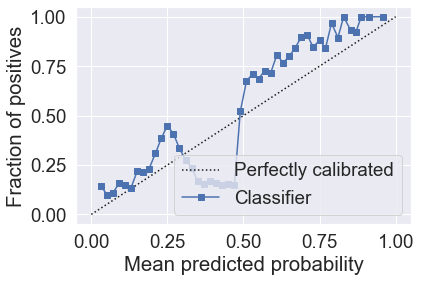

In [81]:
Y_pred = reg.predict_proba(X_2)
disp = CalibrationDisplay.from_predictions(Y_2, Y_pred[:, 1], n_bins=50)
plt.show()

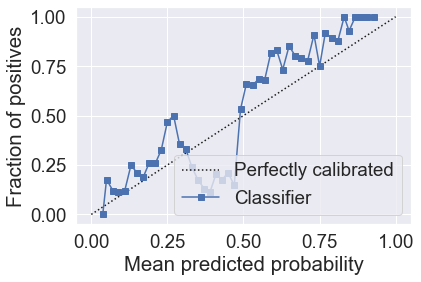

In [99]:
Y_test_pred = reg.predict_proba(X_test)
disp = CalibrationDisplay.from_predictions(Y_test, Y_test_pred[:, 1], n_bins=50)
plt.show()

Графики показывают, что картина похожа на тестовой выборке и на калибровочной: при средних предсказанных вероятностях 0.3-0.5 происходит провал: частота позитивного опускается примерно на уровень 0.2, при этом на всем остальном отрезке $[0, 1]$ частота позитивного класса чуть выше, чем ддолжна быть. Данные не слишком хорошо скалиброваны.

**3.** Реализуйте гистограммную калибровку и примените ее к нашим данным. Изобразите калибровочные кривые. Что можно сказать о результате?

При реализации вам могут помочь функции `np.digitize`, `np.bincount`, `np.unique`.

Давайте разделим отрезок [0, 1] на 50 бинов и сделаем гистограммную калибровку по ним. 

In [117]:
k = 50

bins = np.linspace(0, 1, k + 1)

Y_true = Y_pred[Y_2 == 1]
Y_false = Y_pred[Y_2 == 0]

bin_pred_true = np.digitize(Y_true[:, 1], bins)
bin_pred_false = np.digitize(Y_false[:, 1], bins)
bin_pred_true

array([27,  8, 28, ..., 30, 32, 44], dtype=int64)

In [118]:
count_true = np.bincount(bin_pred_true, minlength = k + 1)
count_false = np.bincount(bin_pred_false, minlength = k + 1)
count_true = count_true[1:]
count_false = count_false[1:]
count_true, count_false

(array([  0,   1,   2,   6,  14,  20,  24,  39,  47,  55,  80,  97, 133,
        119,  97,  80,  69,  45,  41,  51,  44,  40,  42,  34, 112, 134,
        151, 114, 128, 114, 109,  99,  84,  85,  70,  79,  55,  45,  37,
         30,  17,  19,  14,  12,   4,   4,   0,   1,   0,   0], dtype=int64),
 array([  0,   6,  18,  50,  75, 116, 158, 140, 173, 182, 179, 155, 163,
        173, 193, 210, 223, 223, 223, 248, 229, 231, 228, 196, 103,  65,
         61,  52,  48,  45,  26,  30,  21,  16,   8,   8,  10,   6,   7,
          1,   2,   0,   1,   1,   0,   0,   0,   0,   0,   0], dtype=int64))

Объединим первые 4 и последние 11 бинов, чтобы в них не было слишком мало элементов.

In [119]:
first_true = np.sum(count_true[:4])
first_false = np.sum(count_false[:4])
last_true = np.sum(count_true[-11:])
last_false = np.sum(count_false[-11:])
count_true = np.concatenate([[first_true], count_true[4:-11], [last_true]])
count_false = np.concatenate([[first_false], count_false[4:-11], [last_false]])
count_true, count_false

(array([  9,  14,  20,  24,  39,  47,  55,  80,  97, 133, 119,  97,  80,
         69,  45,  41,  51,  44,  40,  42,  34, 112, 134, 151, 114, 128,
        114, 109,  99,  84,  85,  70,  79,  55,  45,  37, 101], dtype=int64),
 array([ 74,  75, 116, 158, 140, 173, 182, 179, 155, 163, 173, 193, 210,
        223, 223, 223, 248, 229, 231, 228, 196, 103,  65,  61,  52,  48,
         45,  26,  30,  21,  16,   8,   8,  10,   6,   7,   5], dtype=int64))

In [131]:
thetas = count_true / (count_true + count_false)
thetas

array([0.10843373, 0.15730337, 0.14705882, 0.13186813, 0.21787709,
       0.21363636, 0.23206751, 0.30888031, 0.38492063, 0.44932432,
       0.40753425, 0.33448276, 0.27586207, 0.23630137, 0.16791045,
       0.15530303, 0.17056856, 0.16117216, 0.14760148, 0.15555556,
       0.14782609, 0.52093023, 0.67336683, 0.71226415, 0.68674699,
       0.72727273, 0.71698113, 0.80740741, 0.76744186, 0.8       ,
       0.84158416, 0.8974359 , 0.90804598, 0.84615385, 0.88235294,
       0.84090909, 0.95283019])

Также сначала построим калибровочную кривую для калибровочных данных, а потом для тестовых.

In [134]:
bins = np.linspace(0, 1, k + 1)

bins = np.concatenate([[0], bins[4:-11], [1]])
bins.shape

(38,)

In [135]:
bin_pred = np.digitize(Y_pred[:, 1], bins)

Z_pred = thetas[bin_pred - 1]
Z_pred

array([0.80740741, 0.71226415, 0.23206751, ..., 0.23206751, 0.76744186,
       0.95283019])

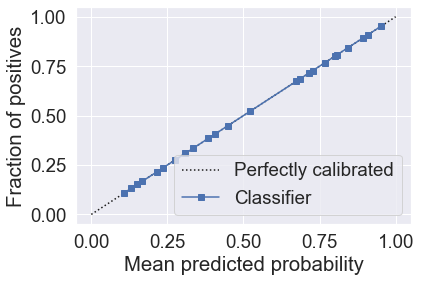

In [136]:
disp = CalibrationDisplay.from_predictions(Y_2, Z_pred, n_bins=50)
plt.show()

Как и ожидалось, кривая почти полностью подстроилась под калибровочные данные. Но давайте теперь посмотрим на тестовые данные.

In [137]:
Y_test_pred = reg.predict_proba(X_test)
bin_test_pred = np.digitize(Y_test_pred[:, 1], bins)
Z_test_pred = thetas[bin_test_pred - 1]
Z_test_pred

array([0.21363636, 0.8974359 , 0.52093023, ..., 0.44932432, 0.76744186,
       0.67336683])

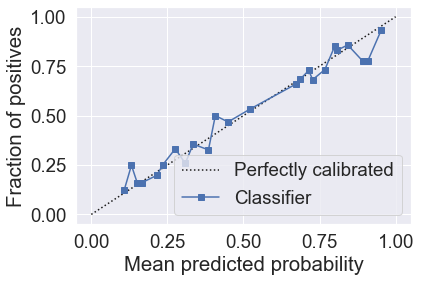

In [138]:
disp = CalibrationDisplay.from_predictions(Y_test, Z_test_pred, n_bins=50)
plt.show()

**Вывод:** видно, что и для тестовых данных калибровка сработала довольно хорошо. Так что, гистограммная калибровка &mdash; действительно хороший метод для калибровки данных.